<a href="https://colab.research.google.com/github/jackeygle/DD2424-Deep-Learning-in-Data-Dcience/blob/main/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Streaming output truncated to the last 5000 lines.
  ** New min smooth loss: 2.9187 at iter 4974 **
  ** New min smooth loss: 2.9182 at iter 4975 **
  ** New min smooth loss: 2.9174 at iter 4976 **
  ** New min smooth loss: 2.9166 at iter 4977 **
  ** New min smooth loss: 2.9154 at iter 4978 **
  ** New min smooth loss: 2.9145 at iter 4979 **
  ** New min smooth loss: 2.9144 at iter 4980 **
  ** New min smooth loss: 2.9133 at iter 4981 **
  ** New min smooth loss: 2.9126 at iter 4982 **
  ** New min smooth loss: 2.9117 at iter 4983 **
  ** New min smooth loss: 2.9111 at iter 4984 **
  ** New min smooth loss: 2.9104 at iter 4985 **
  ** New min smooth loss: 2.9098 at iter 4986 **
  ** New min smooth loss: 2.9091 at iter 4987 **
  ** New min smooth loss: 2.9080 at iter 4988 **
  ** New min smooth loss: 2.9068 at iter 4989 **
  ** New min smooth loss: 2.9060 at iter 4990 **
  ** New min smooth loss: 2.9054 at iter 4991 **
  ** New min smooth loss: 2.9045 at iter 4992 **
  ** New min smoot

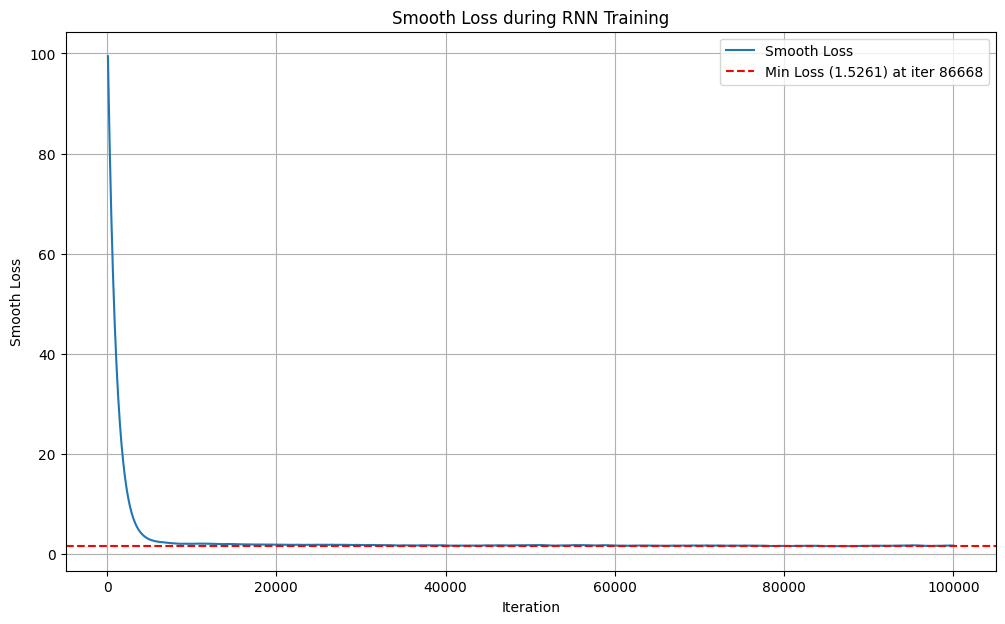


--- Synthesized Texts for Report (includes before training and every 10k updates) ---

Iteration: 0
fWd-jzu(,STrHS4y.vt"lD7IxJ9TK
3
T_g4nK"xeV!
Wtb	_E-nXg1-RTXjbc1KZSCy0}lY.V)x?J_
Vf40QTMBJB9PIL	e!4nü•Y:pbüUT!3c•O I-z/-NVgGvY! PLN"""hZ.Ly(3H71}lhx3uüXuoCEdVH!
,J /}Nx3Fc•ev!BtT12j0R24I,c1jSEZJ(BT,iF4

Iteration: 10000
"
"I levere hers ao sly chat, ance, s arr armaar momberuus, burn nlf to slet serom afire comming the ffleeps, cemale surd rou maly.
"D ster lyoof yea larevery, the forthar al D"
UStmy gor core ond.  "

Iteration: 20000

"Yem of rage cor chernionr. . ."
"Lowe he you ghuin. Ske beared. S" horsed fizards klfted enf tull me forn leak, buck.
"At - they, about Tiscous was on milady got rigrtered, whinngring's ffriep!"  sh

Iteration: 30000
op stle baring shrione, goted wat live of it? nuter wates. . ....
Aly of reothee stoposs the coill scavisel chaupingen o show It heartef wereiny hadpes.
"What you to cand ans of the gamer the rount yo

Iteration: 40000
he gand, whithand-inrie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch # Make sure torch is imported for ComputeGradsWithTorch

# --- PyTorch Gradient Checker Function (Integrated) ---
def ComputeGradsWithTorch(X_np, Y_inds_np, h0_np, RNN_np):
    # assumes X_np has size K x tau (d x tau), Y_inds_np has length tau, h0_np has size m x 1, etc
    tau = X_np.shape[1] # seq_length
    K_dim = X_np.shape[0]   # vocab_size (d)
    m_dim = h0_np.shape[0] # hidden_size

    # Convert numpy inputs to PyTorch tensors
    Xt = torch.from_numpy(X_np).double()
    ht_prev = torch.from_numpy(h0_np).double()

    torch_network = {}
    for kk in RNN_np.keys():
        torch_network[kk] = torch.tensor(RNN_np[kk], requires_grad=True, dtype=torch.double)

    apply_tanh = torch.nn.Tanh()
    apply_softmax = torch.nn.Softmax(dim=0) # Softmax over K characters for each time step

    Hs = torch.empty(m_dim, tau, dtype=torch.float64)
    Os_torch = torch.empty(K_dim, tau, dtype=torch.float64)

    for t in range(tau):
        xt_curr = Xt[:, t:t+1]
        at = torch.matmul(torch_network['W'], ht_prev) + \
             torch.matmul(torch_network['U'], xt_curr) + \
             torch_network['b']
        ht_curr = apply_tanh(at)
        Hs[:, t:t+1] = ht_curr
        ot = torch.matmul(torch_network['V'], ht_curr) + torch_network['c']
        Os_torch[:, t:t+1] = ot
        ht_prev = ht_curr

    P_torch = apply_softmax(Os_torch)

    # Add epsilon for numerical stability before log
    log_probs_correct_char = torch.log(P_torch[Y_inds_np, torch.arange(tau)] + 1e-9)
    loss = -torch.mean(log_probs_correct_char)

    loss.backward()

    grads = {}
    for kk in RNN_np.keys():
        if torch_network[kk].grad is not None:
            grads[kk] = torch_network[kk].grad.numpy()
        else:
            print(f"Warning: No gradient for {kk} in PyTorch.")
            grads[kk] = np.zeros_like(RNN_np[kk])
    return grads
# ----------------------------------------------------

# --- Hyperparameters ---
m = 100  # Dimensionality of hidden state
eta = 0.001  # Learning rate
seq_length = 25  # Length of input sequences
K = 0 # Vocabulary size, will be set after loading data
rng_seed = 42 # For reproducibility
rng = np.random.default_rng(rng_seed)

# Adam parameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# --- Data Loading and Preprocessing ---
def load_data(filename="goblet_book.txt", use_dummy_data_if_not_found=True):
    global K # Allow modification of global K
    try:
        with open(filename, "r", encoding="utf-8") as f:
            book_data = f.read()
        print(f"Successfully loaded {filename}. Length: {len(book_data)} characters.")
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        if use_dummy_data_if_not_found:
            print("Using dummy data instead.")
            book_data = "The quick brown fox jumps over the lazy dog. " * 200 # A bit longer dummy data
            book_data += "Harry Potter and the Goblet of Fire. Hermione Granger. Ron Weasley. Albus Dumbledore. " * 50
            book_data += "The Dark Lord will rise again. Voldemort. Magic is might. " * 50
            print(f"Dummy data length: {len(book_data)} characters.")
        else:
            return None, None, None, None

    unique_chars = sorted(list(set(book_data)))
    K_val = len(unique_chars)
    K = K_val # Set global K here after it's determined
    char_to_ind = {char: i for i, char in enumerate(unique_chars)}
    ind_to_char = {i: char for i, char in enumerate(unique_chars)}
    return book_data, char_to_ind, ind_to_char, K_val

def one_hot_encode(index, vocab_size):
    vec = np.zeros((vocab_size, 1))
    vec[index, 0] = 1
    return vec

# --- RNN Parameters Initialization ---
def initialize_rnn_parameters(m_dim, K_dim):
    RNN = {}
    RNN['b'] = np.zeros((m_dim, 1))
    RNN['c'] = np.zeros((K_dim, 1))
    RNN['U'] = (1/np.sqrt(K_dim)) * rng.standard_normal(size = (m_dim, K_dim)) # Assignment page 4: (1/np.sqrt(2*K_dim))
    RNN['W'] = (1/np.sqrt(m_dim)) * rng.standard_normal(size = (m_dim, m_dim)) # Assignment page 4: (1/np.sqrt(2*m_dim))
    RNN['V'] = (1/np.sqrt(m_dim)) * rng.standard_normal(size = (K_dim, m_dim)) # Assignment page 4: (1/np.sqrt(m_dim))

    # Correcting to strictly follow page 4 of assignment for initialization
    RNN['U'] = (1/np.sqrt(2*K_dim)) * rng.standard_normal(size = (m_dim, K_dim))
    RNN['W'] = (1/np.sqrt(2*m_dim)) * rng.standard_normal(size = (m_dim, m_dim))
    # RNN['V'] initialization was correct as per page 4 already.

    return RNN

# --- Softmax ---
def softmax(x):
    # Subtract max for numerical stability (prevents overflow with large exponents)
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

# --- Forward Pass ---
def forward_pass(X_seq, h_prev, RNN_params):
    W, U, V, b, c = RNN_params['W'], RNN_params['U'], RNN_params['V'], RNN_params['b'], RNN_params['c']
    seq_len = X_seq.shape[1]
    m_dim = W.shape[0]
    K_dim = V.shape[0]

    a_vals = np.zeros((m_dim, seq_len))
    h_vals = np.zeros((m_dim, seq_len + 1))
    o_vals = np.zeros((K_dim, seq_len))
    p_vals = np.zeros((K_dim, seq_len))

    h_vals[:, 0:1] = h_prev

    for t in range(seq_len):
        xt = X_seq[:, t:t+1]
        a_vals[:, t:t+1] = W @ h_vals[:, t:t+1] + U @ xt + b
        h_vals[:, t+1:t+2] = np.tanh(a_vals[:, t:t+1])
        o_vals[:, t:t+1] = V @ h_vals[:, t+1:t+2] + c
        p_vals[:, t:t+1] = softmax(o_vals[:, t:t+1])

    return a_vals, h_vals, o_vals, p_vals, h_vals[:, -1:]

def calculate_loss(p_vals, Y_inds):
    seq_len = Y_inds.shape[0]
    loss = 0
    for t in range(seq_len):
        # Add small epsilon for log(0) stability
        loss -= np.log(p_vals[Y_inds[t], t] + 1e-9)
    return loss / seq_len # Average loss

# --- Backward Pass ---
def backward_pass(X_seq, Y_inds, RNN_params, a_vals, h_vals, o_vals, p_vals):
    W, U, V, b, c = RNN_params['W'], RNN_params['U'], RNN_params['V'], RNN_params['b'], RNN_params['c']
    seq_len = X_seq.shape[1]
    m_dim = W.shape[0]

    grads = {key: np.zeros_like(val) for key, val in RNN_params.items()}
    grad_o = np.copy(p_vals)
    for t in range(seq_len):
        grad_o[Y_inds[t], t] -= 1
    grad_o /= seq_len # Average gradient because loss was averaged

    for t in range(seq_len): # This loop should be outside grad_h_next loop
        grads['V'] += np.outer(grad_o[:, t], h_vals[:, t+1])
        grads['c'] += grad_o[:, t:t+1]

    grad_h_next = np.zeros((m_dim, 1))
    for t in reversed(range(seq_len)):
        grad_h = V.T @ grad_o[:, t:t+1] + grad_h_next
        grad_a = grad_h * (1 - h_vals[:, t+1:t+2]**2)

        grads['W'] += np.outer(grad_a, h_vals[:, t])
        grads['U'] += np.outer(grad_a, X_seq[:, t])
        grads['b'] += grad_a

        grad_h_next = W.T @ grad_a

    for key in grads: # Clip gradients
        grads[key] = np.clip(grads[key], -5.0, 5.0)
    return grads

# --- Adam Optimizer ---
def initialize_adam(params):
    m_adam = {}
    v_adam = {}
    for key in params:
        m_adam[key] = np.zeros_like(params[key])
        v_adam[key] = np.zeros_like(params[key])
    return m_adam, v_adam

def update_parameters_adam(params, grads, m_adam, v_adam, t_adam, learning_rate, beta1_adam, beta2_adam, epsilon_adam):
    for key in params:
        m_adam[key] = beta1_adam * m_adam[key] + (1 - beta1_adam) * grads[key]
        v_adam[key] = beta2_adam * v_adam[key] + (1 - beta2_adam) * (grads[key]**2)
        m_hat = m_adam[key] / (1 - beta1_adam**t_adam)
        v_hat = v_adam[key] / (1 - beta2_adam**t_adam)
        params[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)
    return params, m_adam, v_adam

# --- Text Synthesis ---
def synthesize_text(RNN_params, h0_syn, x0_ind_syn, n_chars_syn, K_dim_syn, ind_to_char_map, char_to_ind_map):
    W, U, V, b, c = RNN_params['W'], RNN_params['U'], RNN_params['V'], RNN_params['b'], RNN_params['c']
    x_curr = one_hot_encode(x0_ind_syn, K_dim_syn)
    h_curr = np.copy(h0_syn)
    generated_indices = []

    for _ in range(n_chars_syn):
        a = W @ h_curr + U @ x_curr + b
        h_curr = np.tanh(a)
        o = V @ h_curr + c
        p = softmax(o)

        cp = np.cumsum(p.ravel())
        rand_val = rng.uniform()
        ix = np.argmax(cp - rand_val > 0)
        # Safety check, though with correct cumsum and rand_val in [0,1), ix should be valid
        if ix >= K_dim_syn: ix = K_dim_syn -1

        generated_indices.append(ix)
        x_curr = one_hot_encode(ix, K_dim_syn)

    return "".join([ind_to_char_map[ix_char] for ix_char in generated_indices])


import copy # Needed for deepcopying the best model parameters

# ... (之前的 ComputeGradsWithTorch, Hyperparameters, Data Loading, etc. 保持不变) ...
# ... (initialize_rnn_parameters, softmax, forward_pass, calculate_loss, backward_pass, initialize_adam, update_parameters_adam, synthesize_text 保持不变) ...

# --- Gradient Checking ---
# 修改点 1: 将 seq_len_gc 的默认值和调用时的值改为25
def check_gradients(char_to_ind_map_check, K_dim_check, m_dim_check=10, seq_len_gc=25): # MODIFIED: seq_len_gc default to 25
    print("\n--- Starting Gradient Check ---")
    # ... (内部逻辑不变，除了 seq_len_gc 会使用新的值) ...

    available_chars = list(char_to_ind_map_check.keys())
    if len(available_chars) < seq_len_gc + 1:
        print(f"Warning: Not enough unique characters ({len(available_chars)}) for gradient check sequence length ({seq_len_gc}+1).")
        if len(available_chars) < 2:
            print("Error: Need at least 2 unique characters for gradient checking. Skipping.")
            return False
        # If still not enough after trying to use all, it might fail or use a shorter seq.
        # For strictness, we might want to ensure seq_len_gc can actually be met.
        # However, the assignment implies K is from the book, so it should be large enough.
        # If K is small from dummy data, this part might need more robust handling or a skip.
        # For now, assume K from actual book data is sufficient for seq_len_gc=25.
        if len(available_chars) <= seq_len_gc : # if we only have exactly seq_len_gc chars, we can't make Y
             print(f"Error: Not enough unique characters to form X and Y for seq_len_gc={seq_len_gc}. Skipping gradient check.")
             return False # Cannot proceed if not enough data for X and Y


    dummy_chars_X = available_chars[:seq_len_gc]
    dummy_chars_Y = available_chars[1:seq_len_gc+1]

    X_check = np.zeros((K_dim_check, seq_len_gc))
    Y_inds_check = np.zeros(seq_len_gc, dtype=int)

    for t, char_val in enumerate(dummy_chars_X):
        X_check[:, t] = one_hot_encode(char_to_ind_map_check[char_val], K_dim_check)[:,0]
    for t, char_val in enumerate(dummy_chars_Y):
        Y_inds_check[t] = char_to_ind_map_check[char_val]

    h0_check = np.zeros((m_dim_check, 1))
    RNN_check = initialize_rnn_parameters(m_dim_check, K_dim_check)

    a_vals_c, h_vals_c, o_vals_c, p_vals_c, _ = forward_pass(X_check, h0_check, RNN_check)
    grads_analytical = backward_pass(X_check, Y_inds_check, RNN_check, a_vals_c, h_vals_c, o_vals_c, p_vals_c)
    grads_pytorch = ComputeGradsWithTorch(X_check, Y_inds_check, h0_check, RNN_check)

    print("Comparing gradients (Max absolute difference & Avg Relative Error):")
    all_passed = True
    for key in RNN_check:
        abs_diff = np.abs(grads_analytical[key] - grads_pytorch[key])
        max_abs_diff_val = np.max(abs_diff)
        rel_error_num = np.sum(abs_diff)
        rel_error_den = np.sum(np.abs(grads_analytical[key]) + np.abs(grads_pytorch[key])) + 1e-9
        avg_rel_error = rel_error_num / rel_error_den

        print(f"Param: {key}, Max Abs Diff: {max_abs_diff_val:.2e}, Avg Rel Error: {avg_rel_error:.2e}")
        if max_abs_diff_val > 1e-6 or avg_rel_error > 1e-5 :
            print(f"  WARNING: Gradients for {key} might differ significantly.")
            all_passed = False

    if all_passed:
        print("Gradient check PASSED (within tolerance).")
    else:
        print("Gradient check FAILED for some parameters.")
    print("--- Gradient Check Finished ---")
    return all_passed


# --- Main Training Loop ---
def train_rnn():
    global K
    book_file = "goblet_book.txt"
    book_data, char_to_ind, ind_to_char, K_val_loaded = load_data(book_file, use_dummy_data_if_not_found=True)

    if K_val_loaded is None:
        print(f"Could not load data from {book_file} and dummy data was not used. Exiting.")
        return
    K = K_val_loaded

    print(f"Vocabulary size (K): {K}")
    print(f"Hidden state size (m): {m}")
    print(f"Sequence length: {seq_length}")

    # 修改点 1 (调用): Gradient Check first (m=10, seq_length=25 (as per assignment page 5, last paragraph))
    if not check_gradients(char_to_ind, K, m_dim_check=10, seq_len_gc=25): # MODIFIED: seq_len_gc to 25
         print("Gradient check issues. Please review before extensive training.")
         return

    RNN_params = initialize_rnn_parameters(m, K)
    adam_m_params, adam_v_params = initialize_adam(RNN_params)

    e_ptr = 0
    h_prev_state = np.zeros((m, 1))
    smooth_loss_val = -np.log(1.0/K) * seq_length
    adam_iter_count = 0

    # 修改点 2: 初始化用于保存最佳模型和最低损失的变量
    min_smooth_loss = float('inf')
    best_RNN_params = None
    iteration_of_best_loss = 0

    num_epochs_train = 3
    iterations_per_epoch = len(book_data) // seq_length
    total_iterations_train = 100000

    losses_history = []
    iteration_points_history = []

    print(f"\nStarting training for {total_iterations_train} iterations...")
    start_time_total_train = time.time()

    synthesized_texts_for_report = []
    if K > 0 and len(char_to_ind)>0:
        first_char_of_book = book_data[0] if book_data else list(char_to_ind.keys())[0]
        first_char_idx_init = char_to_ind.get(first_char_of_book, 0)
        initial_h0_for_synth = np.zeros((m,1))
        text_before_train = synthesize_text(RNN_params, initial_h0_for_synth, first_char_idx_init, 200, K, ind_to_char, char_to_ind)
        synthesized_texts_for_report.append((0, text_before_train))
        print(f"Iter: 0 (Before training), Synthesized:\n{text_before_train}\n---")


    for iteration in range(1, total_iterations_train + 1):
        adam_iter_count += 1
        if e_ptr + seq_length + 1 >= len(book_data):
            e_ptr = 0
            h_prev_state = np.zeros((m, 1))
            # current_epoch_approx = iteration // iterations_per_epoch if iterations_per_epoch > 0 else 0
            # print(f"--- Completed Epoch (approx) {current_epoch_approx} ---")

        X_chars_batch = book_data[e_ptr : e_ptr + seq_length]
        Y_chars_batch = book_data[e_ptr + 1 : e_ptr + seq_length + 1]

        X_one_hot_batch = np.zeros((K, seq_length))
        Y_inds_batch = np.zeros(seq_length, dtype=int)

        for t_idx, char_val in enumerate(X_chars_batch):
            X_one_hot_batch[:, t_idx] = one_hot_encode(char_to_ind[char_val], K)[:,0]
        for t_idx, char_val in enumerate(Y_chars_batch):
            Y_inds_batch[t_idx] = char_to_ind[char_val]

        a_vals_fwd, h_vals_fwd, o_vals_fwd, p_vals_fwd, h_next_state = forward_pass(X_one_hot_batch, h_prev_state, RNN_params)
        current_loss_val = calculate_loss(p_vals_fwd, Y_inds_batch)
        grads_bwd = backward_pass(X_one_hot_batch, Y_inds_batch, RNN_params, a_vals_fwd, h_vals_fwd, o_vals_fwd, p_vals_fwd)

        RNN_params, adam_m_params, adam_v_params = update_parameters_adam(
            RNN_params, grads_bwd, adam_m_params, adam_v_params, adam_iter_count, eta, beta1, beta2, epsilon
        )

        smooth_loss_val = 0.999 * smooth_loss_val + 0.001 * current_loss_val
        h_prev_state = h_next_state

        # 修改点 2: 跟踪并保存最佳模型
        if smooth_loss_val < min_smooth_loss:
            min_smooth_loss = smooth_loss_val
            best_RNN_params = copy.deepcopy(RNN_params) # Use deepcopy for dictionaries of numpy arrays
            iteration_of_best_loss = iteration
            print(f"  ** New min smooth loss: {min_smooth_loss:.4f} at iter {iteration} **")


        if iteration % 100 == 0:
            elapsed_time_iter = time.time() - start_time_total_train
            print(f"Iter: {iteration}/{total_iterations_train}, Smooth Loss: {smooth_loss_val:.4f}, Min Smooth Loss: {min_smooth_loss:.4f} (at iter {iteration_of_best_loss}), Time: {elapsed_time_iter:.2f}s")
            losses_history.append(smooth_loss_val)
            iteration_points_history.append(iteration)

        if iteration % 10000 == 0:
            print(f"--- Synthesized text at iter {iteration} ---")
            first_char_current_seq_idx = char_to_ind[X_chars_batch[0]]
            synthesized_iter = synthesize_text(RNN_params, h_prev_state, first_char_current_seq_idx, 200, K, ind_to_char, char_to_ind)
            print(synthesized_iter)
            synthesized_texts_for_report.append((iteration, synthesized_iter))
            print("---")

        e_ptr += seq_length

    print("Training finished.")

    plt.figure(figsize=(12,7))
    if iteration_points_history and losses_history:
        plt.plot(iteration_points_history, losses_history, label="Smooth Loss")
        # Optionally, mark the point of minimum smooth loss
        if iteration_of_best_loss in iteration_points_history:
             idx_best = iteration_points_history.index(iteration_of_best_loss)
             plt.scatter([iteration_of_best_loss], [losses_history[idx_best]], color='red', s=100, label=f'Min Loss ({min_smooth_loss:.4f})', zorder=5)
        elif best_RNN_params is not None : # If best iter was not exactly on a 100th step
             plt.axhline(y=min_smooth_loss, color='r', linestyle='--', label=f'Min Loss ({min_smooth_loss:.4f}) at iter {iteration_of_best_loss}')

        plt.xlabel("Iteration")
        plt.ylabel("Smooth Loss")
        plt.title("Smooth Loss during RNN Training")
        plt.legend()
        plt.grid(True)
        plt.savefig("smooth_loss_plot.png")
        plt.show()
    else:
        print("No loss history to plot.")

    print("\n--- Synthesized Texts for Report (includes before training and every 10k updates) ---")
    for iter_num, text_sample in synthesized_texts_for_report:
        print(f"\nIteration: {iter_num}\n{text_sample}")

    # 修改点 2: 使用最佳模型进行最终文本合成
    print(f"\n--- Final Synthesized Text (1000 chars) from best model (achieved at iter {iteration_of_best_loss} with loss {min_smooth_loss:.4f}) ---")
    if best_RNN_params is not None and K > 0 and len(char_to_ind)>0:
        start_char_final_synth = '.' if '.' in char_to_ind else list(char_to_ind.keys())[0]
        start_idx_final_synth = char_to_ind.get(start_char_final_synth,0)
        # For final synthesis, it's good practice to start with a fresh h0, or the h_prev from when best_RNN_params was saved.
        # Here, we'll use a fresh h0 for consistency, as h_prev from that specific iteration wasn't saved.
        final_h0_for_best_model = np.zeros((m,1))
        final_long_text = synthesize_text(best_RNN_params, final_h0_for_best_model, start_idx_final_synth, 1000, K, ind_to_char, char_to_ind)
        print(final_long_text)
        with open("final_synthesized_text_best_model.txt", "w", encoding="utf-8") as f:
            f.write(final_long_text)
        print(f"\nSaved final 1000-char synthesized text (from best model) to final_synthesized_text_best_model.txt")
    elif K == 0 or len(char_to_ind) == 0:
        print("Cannot synthesize final text, K or char_to_ind is not valid.")
    else:
        print("No best model was saved (perhaps training was too short or an error occurred). Synthesizing with final model instead.")
        # Fallback to final model if best_RNN_params is None (shouldn't happen if training runs)
        if K > 0 and len(char_to_ind)>0:
            start_char_final_synth = '.' if '.' in char_to_ind else list(char_to_ind.keys())[0]
            start_idx_final_synth = char_to_ind.get(start_char_final_synth,0)
            final_h0_for_final_model = np.zeros((m,1))
            final_long_text_fallback = synthesize_text(RNN_params, final_h0_for_final_model, start_idx_final_synth, 1000, K, ind_to_char, char_to_ind)
            print(final_long_text_fallback)
            with open("final_synthesized_text_final_model.txt", "w", encoding="utf-8") as f:
                f.write(final_long_text_fallback)
            print(f"\nSaved final 1000-char synthesized text (from final model as fallback) to final_synthesized_text_final_model.txt")


    print("Saved loss plot to smooth_loss_plot.png (if history was recorded)")

if __name__ == "__main__":
    # ... (Colab instructions remain the same) ...
    train_rnn()